In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
import random
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR as lr_scheduler
import matplotlib.pyplot as plt

In [2]:
celebA_path = "/home/tomi64/projects/melytanulas_project/celebA"
Flowers102_path = "/home/tomi64/projects/melytanulas_project/Flower102"


celebA = torchvision.datasets.CelebA(root = celebA_path, download=True)
Flowers102 = torchvision.datasets.Flowers102(root = Flowers102_path, download=True)

Files already downloaded and verified


In [3]:
IMAGE_SIZE=112
BATCH_SIZE=24

In [4]:
class DataWithNoise(torch.utils.data.Dataset):
    def __init__(self, dataset, transforms, timesteps):
        self.dataset = dataset
        self.transforms = transforms
        self.timesteps = timesteps
        self.beta_schedule = torch.linspace(1e-4, 2e-2, timesteps)
        #self.alpha_schedule = torch.cumprod(1-self.beta_schedule, dim=0)
        self.alpha_schedule = torch.cos(torch.linspace(0, 3.1415/2, timesteps))
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, _ = self.dataset[idx]

        image = self.transforms(image)
        
        noise = torch.randn_like(image)
        t = random.randint(0, self.timesteps-1)
        noisy_image = torch.sqrt(self.alpha_schedule[t])*image+(1-self.alpha_schedule[t])*noise
        return noisy_image, noise, torch.Tensor([t])


In [5]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*2-1)
])
Flowers102_with_noise = DataWithNoise(Flowers102, transform, 500)
celeba_with_noise = DataWithNoise(celebA, transform, 500)

tensor([296.])


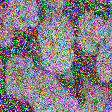

In [6]:
back_transforms = transforms.Compose([
    transforms.Lambda(lambda x: (x+1)/2),
    transforms.ToPILImage(),
])
n_image = Flowers102_with_noise[0]
print(n_image[2])
back_transforms(n_image[0])

In [7]:
dataloader_celebA = DataLoader(celeba_with_noise, batch_size=BATCH_SIZE, shuffle=True)
dataloader_Flower102 = DataLoader(Flowers102_with_noise, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
class Level(nn.Module):
    def __init__(self, inch, och, dim):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(inch)
        self.conv1 = nn.Conv2d(inch, och, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(och)
        self.conv2 = nn.Conv2d(och, och, 3, 1, 1)
        self.act = nn.ReLU()
        self.time_embedding = nn.Sequential(
            Sinusoidal_embedding(dim),
            nn.Linear(dim, och),
            nn.ReLU()
        )
    
    def __call__(self, x, t):
        return self.forward(x, t)
    
    def forward(self, x, t):
        x = self.bn1(x)
        x = self.conv1(x)
        x = self.act(x)

        #embedding = self.time_embedding(t)
        #embedding = embedding[(..., ) + (None, ) * 2]
        #x = x+embedding

        x = self.bn2(x)
        x = self.conv2(x)
        x = self.act(x)

        return x

class Upconv(nn.Module):
    def __init__(self, inch, och):
        super().__init__()
        self.bn = nn.BatchNorm2d(inch)
        self.conv = nn.ConvTranspose2d(inch, och, 2, 2)
        self.act = nn.ReLU()

    def __call__(self, x):
        return self.forward(x)
    
    def forward(self, x):
        x = self.bn(x)
        x = self.conv(x)
        x = self.act(x)

        return x
    
class Sinusoidal_embedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def __call__(self, t):
        return self.forward(t)
    
    def forward(self, t):
        device = t.device
        half_dim = self.dim//2
        exp_sin = torch.linspace(0, 1, half_dim, device=device)
        exp_cos = torch.linspace(0, 1, half_dim, device=device)
        exp_sin = torch.sin(t*10000**exp_sin)
        exp_cos = torch.cos(t*10000**exp_cos)
        embedding = torch.cat((exp_sin, exp_cos), dim=-1)
        return embedding


class Unet(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.downlevel1 = Level(3, 64, dim)
        self.downlevel2 = Level(64, 128, dim)
        self.downlevel3 = Level(128, 256, dim)
        self.downlevel4 = Level(256, 512, dim)
        self.downlevel5 = Level(512, 1024, dim)
        self.uplevel1 = Level(1024, 512, dim)
        self.uplevel2 = Level(512, 256, dim)
        self.uplevel3 = Level(256, 128, dim)
        self.uplevel4 = Level(128, 64, dim)
        self.pool = nn.MaxPool2d(2, 2)
        self.upconv1 = Upconv(1024, 512)
        self.upconv2 = Upconv(512, 256)
        self.upconv3 = Upconv(256, 128)
        self.upconv4 = Upconv(128, 64)
        self.bn1 = nn.BatchNorm2d(64)
        self.lastconv = nn.Conv2d(64, 3, 1)
        self.bn2 = nn.BatchNorm2d(3)
        self.act = nn.Sigmoid()
    
    def __call__(self, x, t):
        return self.forward(x, t)
    
    def forward(self, x, t):
        x = self.downlevel1(x, t)
        residual1 = x
        x = self.pool(x)
        
        x = self.downlevel2(x, t)
        residual2 = x
        x = self.pool(x)

        x = self.downlevel3(x, t)
        residual3 = x
        x = self.pool(x)

        x = self.downlevel4(x, t)
        residual4 = x
        x = self.pool(x)

        x = self.downlevel5(x, t)

        x = self.upconv1(x)
        x = torch.cat([residual4, x], 1)
        x = self.uplevel1(x, t)

        x = self.upconv2(x)
        x = torch.cat([residual3, x], 1)
        x = self.uplevel2(x, t)
        
        x = self.upconv3(x)
        x = torch.cat([residual2, x], 1)
        x = self.uplevel3(x, t)

        x = self.upconv4(x)
        x = torch.cat([residual1, x], 1)
        x = self.uplevel4(x, t)

        x = self.bn1(x)
        x = self.lastconv(x)
        #x = self.bn2(x)
        #x = self.act(x)

        return x

In [9]:
class Medium_Unet(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.downlevel1 = Level(3, 32, dim)
        self.downlevel2 = Level(32, 64, dim)
        self.downlevel3 = Level(64, 128, dim)
        self.downlevel4 = Level(128, 256, dim)
        self.downlevel5 = Level(256, 512, dim)
        self.uplevel1 = Level(512, 256, dim)
        self.uplevel2 = Level(256, 128, dim)
        self.uplevel3 = Level(128, 64, dim)
        self.uplevel4 = Level(64, 32, dim)
        self.pool = nn.MaxPool2d(2, 2)
        self.upconv1 = Upconv(512, 256)
        self.upconv2 = Upconv(256, 128)
        self.upconv3 = Upconv(128, 64)
        self.upconv4 = Upconv(64, 32)
        self.bn1 = nn.BatchNorm2d(32)
        self.lastconv = nn.Conv2d(32, 3, 1)
        self.bn2 = nn.BatchNorm2d(3)
        self.act = nn.Sigmoid()
    
    def __call__(self, x, t):
        return self.forward(x, t)
    
    def forward(self, x, t):
        x = self.downlevel1(x, t)
        residual1 = x
        x = self.pool(x)
        
        x = self.downlevel2(x, t)
        residual2 = x
        x = self.pool(x)

        x = self.downlevel3(x, t)
        residual3 = x
        x = self.pool(x)

        x = self.downlevel4(x, t)
        residual4 = x
        x = self.pool(x)

        x = self.downlevel5(x, t)

        x = self.upconv1(x)
        x = torch.cat([residual4, x], 1)
        x = self.uplevel1(x, t)

        x = self.upconv2(x)
        x = torch.cat([residual3, x], 1)
        x = self.uplevel2(x, t)
        
        x = self.upconv3(x)
        x = torch.cat([residual2, x], 1)
        x = self.uplevel3(x, t)

        x = self.upconv4(x)
        x = torch.cat([residual1, x], 1)
        x = self.uplevel4(x, t)

        x = self.bn1(x)
        x = self.lastconv(x)
        #x = self.bn2(x)
        #x = self.act(x)

        return x

In [10]:
x = torch.rand((1, 3, 112, 112))
model = Unet(32)
t = torch.Tensor([10])

model(x, t)

tensor([[[[ 0.2621,  0.5529,  0.3134,  ..., -0.1946,  0.2667,  0.0378],
          [-0.2445,  0.2795,  0.5228,  ..., -1.1538,  0.3221, -0.4338],
          [ 0.6178,  0.4098,  0.0403,  ..., -0.4169,  0.6300, -0.0167],
          ...,
          [-0.0036, -0.2153,  0.1572,  ...,  0.6899,  0.1122,  0.6088],
          [ 0.2066, -0.0690,  0.7290,  ...,  0.1104,  0.0052,  0.4271],
          [ 0.1897,  0.6000,  0.5770,  ..., -0.0133,  0.5229, -0.0932]],

         [[ 0.0082, -0.1569, -0.1073,  ...,  0.0749, -0.4569, -0.1622],
          [-0.5297, -0.3125,  0.0383,  ..., -0.3891, -0.2484,  0.0290],
          [-0.4137, -0.1097, -0.4369,  ...,  0.3602,  0.1147,  0.4214],
          ...,
          [-0.2686, -0.3825,  0.0570,  ..., -0.3450,  0.1523,  0.1732],
          [-0.7495, -0.2616, -0.5045,  ..., -0.0070, -0.5380,  0.0040],
          [-0.4360, -0.3890, -0.2679,  ..., -0.0403, -0.1416, -0.3306]],

         [[-0.0517,  0.5805, -0.0270,  ..., -0.6010,  0.3746,  0.3020],
          [ 0.5335, -0.0628, -

In [179]:
lr = 1e-4
lr_ratio = 1e-3
num_epoch = 3
model = Unet(32).cuda()

def criterion(x, y):
    return torch.sum((x-y)**2)

optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = lr_scheduler(optimizer, num_epoch, lr*lr_ratio)
#train_loader = DataLoader(Flowers102_with_noise, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(celeba_with_noise, batch_size=BATCH_SIZE, shuffle=True)


In [175]:
def train_loop(num_epoch, model, optimizer, scheduler, train_loader, criterion):
    for epoch in range(num_epoch):
        tepoch = tqdm(train_loader, leave=True, position=0)
        sum_loss = 0
        i = 0
        for noisy_image, noise, t in tepoch:
            i+=1
            optimizer.zero_grad()

            noisy_image = noisy_image.cuda()
            noise = noise.cuda()
            t = t.cuda()

            output = model(noisy_image, t)
            loss = criterion(noise, output)
            loss.backward()

            optimizer.step()

            sum_loss += loss.item()
            running_loss = sum_loss / (i*BATCH_SIZE)

            tepoch.set_postfix(epoch = epoch, loss=running_loss)
            tepoch.refresh()

            scheduler.step()

In [176]:
def batch_train_loop(num_epoch, model, optimizer, scheduler, batch, criterion):
    tepoch = tqdm(range(num_epoch), position=0)
    for epoch in tepoch:
        noisy_image, noise, t = batch
        optimizer.zero_grad()

        noisy_image = noisy_image.cuda()
        noise = noise.cuda()
        t = t.cuda()

        output = model(noisy_image, t)
        #print(t)
        #print(f'pred_noise: {output}')
        #print(f'gt_noise: {noise}')

        loss = criterion(noise, output)
        loss.backward()

        optimizer.step()

        tepoch.set_postfix(epoch = epoch, loss=loss.item())
        tepoch.refresh()

        scheduler.step()

In [178]:
num_epoch = 1000
#t = next(iter(train_loader))[2][0].unsqueeze(0)
#batch = (next(iter(train_loader))[0][0].unsqueeze(0), next(iter(train_loader))[1][0].unsqueeze(0), t)
batch = next(iter(train_loader))
#print(t)

batch_train_loop(num_epoch, model, optimizer, scheduler, batch, criterion)

100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s, epoch=999, loss=20.9]  


In [215]:
3.38e+3

3380.0

In [216]:
noisy_image, noise, t = batch
torch.cuda.empty_cache()

noisy_image = noisy_image.cuda()
noise = noise.cuda()
t = t.cuda()

diff = model(noisy_image, t)[0]-noise[0]

In [217]:
torch.sum(abs(diff))
#diff.shape
#64/(3*112*112)

tensor(111.3722, device='cuda:0', grad_fn=<SumBackward0>)

In [180]:
train_loop(num_epoch, model, optimizer, scheduler, train_loader, criterion)

100%|██████████| 6783/6783 [40:07<00:00,  2.82it/s, epoch=2, loss=5.49e+3]


In [181]:
torch.save(model.state_dict(), './model_celeb.pt')

In [197]:
@torch.no_grad()
def generate_image(model, x_t, T = 300):
    beta = torch.linspace(1e-4, 2e-2, T).cuda()
    alpha = (1-beta).cuda()
    alpha_cumprod = torch.cumprod(alpha, dim=0).cuda()
    #alpha_cumprod = torch.cos(torch.linspace(0, 3.1415/2, T))

    for t in reversed(range(T)):
        x_t = timestep(model, x_t, t, beta, alpha, alpha_cumprod)
    return x_t


@torch.no_grad()
def timestep(model, x_t, t, beta, alpha, alpha_cumrpod):
    if t==0:
        z = torch.zeros_like(x).cuda()
    else:
        z = torch.randn_like(x).cuda()
    sigma_t = beta[t].cuda()
    model_coeff = ((1-alpha[t])/torch.sqrt(1-alpha_cumrpod[t])).cuda()
    main_coeff = (1/torch.sqrt(alpha[t])).cuda()
    noise = model(x_t, torch.tensor([t]).cuda())
    #print(model_coeff)
    #print(main_coeff)
    return main_coeff*(x_t-model_coeff*noise)+sigma_t*z

In [198]:
def min_max_scale(x):
    return (x-torch.min(x))/(torch.max(x)-torch.min(x))

In [232]:
x_T = torch.randn([1, 3, 112, 112]).cuda()
x = generate_image(model, x_T)

In [233]:
y = min_max_scale(x)

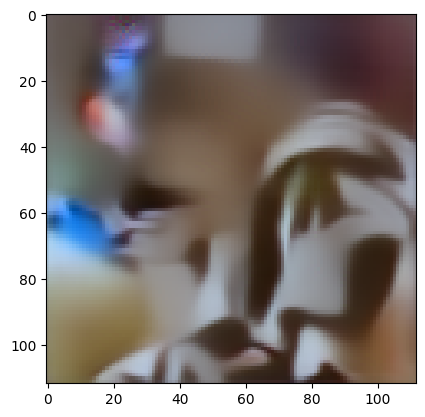

In [234]:
y = (y.cpu().detach())[0].permute(1, 2, 0)
plt.imshow(y)